# Creazione modelli per previsione SQUAT
> Decision TreeClassifier

> Logistic Regression 

> Regressione lineare multivariata

In [56]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

In [57]:
max_lunghezza_albero = 100
potatura = 0.001

shift = 5
soglia_prob = 0.5
rolling_prob = 10

## Import dati

In [58]:
df_raw = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/Squatprob.csv' , sep=';' , decimal='.')
df_raw.set_index('Time', inplace=True)
# df

In [59]:
df = df_raw.copy()

In [60]:
# applico uno shift per ogni posizione i con ['DOWN']==1, 
# assegno alle righe prima e dopo ['DOWN']=1
# numero di righe determinato da [shift]

df_temp = df.loc[df['DOWN'] ==1]
pos = np.array(df_temp.index)

for i in pos:
    for k in range(-shift+1, shift, 1):
        df.at[i+k, 'DOWN'] =1


df.dropna(inplace=True)

## Preparazione datasets

In [61]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP','prob'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Modelli

## DecisionTree Classifier

In [62]:
potatura = 0.005

Accuracy:   0.953
Precision:  0.769
Recall:     0.588


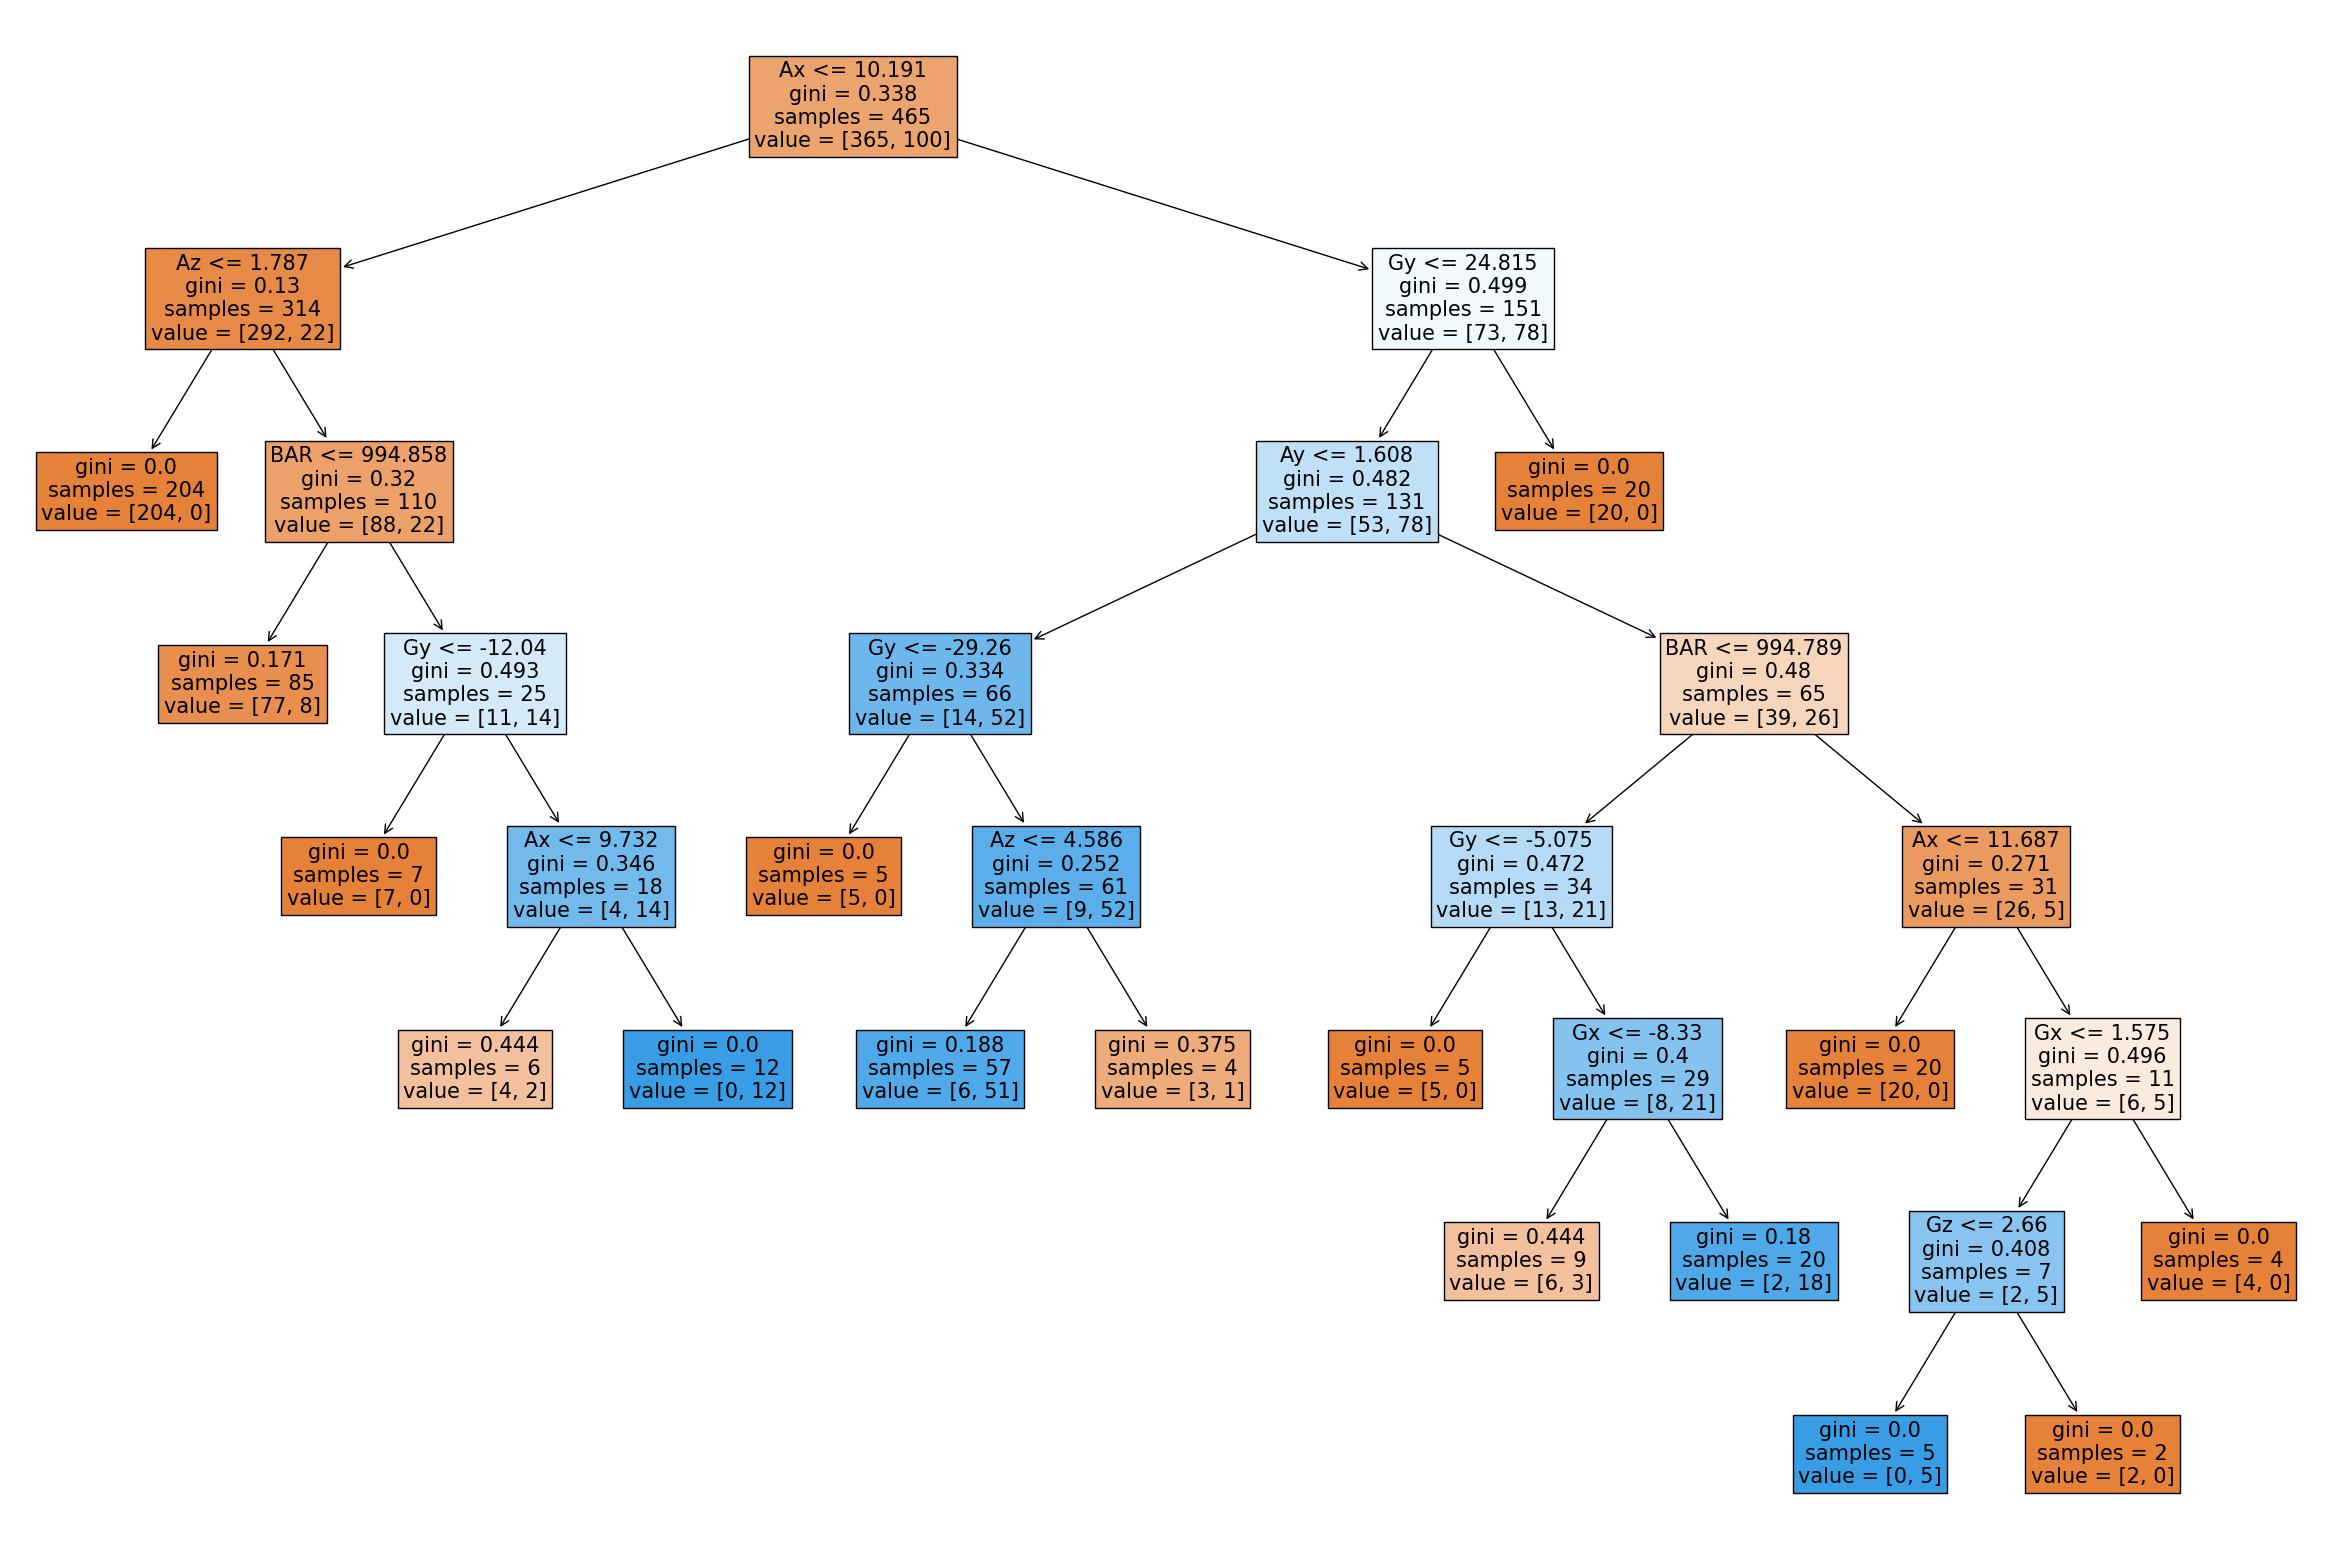

In [63]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_lunghezza_albero , ccp_alpha=potatura)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


In [64]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
# feature_importance.head(10).plot(kind='bar')

            0
Ax   0.392885
Gy   0.246596
BAR  0.126175
Ay   0.082122
Az   0.073544
Gx   0.054867
Gz   0.023811
P    0.000000
R    0.000000


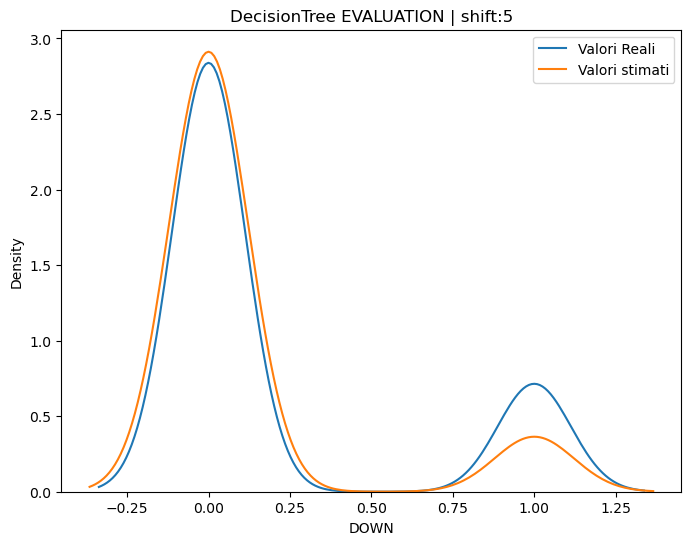

In [65]:
plt.figure(figsize=(8, 6))
plt.title('DecisionTree EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(predictions , label='Valori stimati')
plt.legend()
plt.show()

## Logistic Regression

In [66]:
log_reg = LogisticRegression(random_state=None, solver = 'lbfgs', max_iter=10000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)
print('Termine noto:',log_reg.intercept_[0])

     Logistic
Reg          
Ay  -1.246804
Az   0.545518
Ax   0.539637
BAR -0.005986
Gz  -0.004428
Gy   0.002403
Gx   0.001519
P         0.0
R         0.0
Termine noto: 6.502567356963135e-05


In [67]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report


LogReg Training Accuracy is:  0.843010752688172
LogReg Testing Accuracy is:  0.8632478632478633


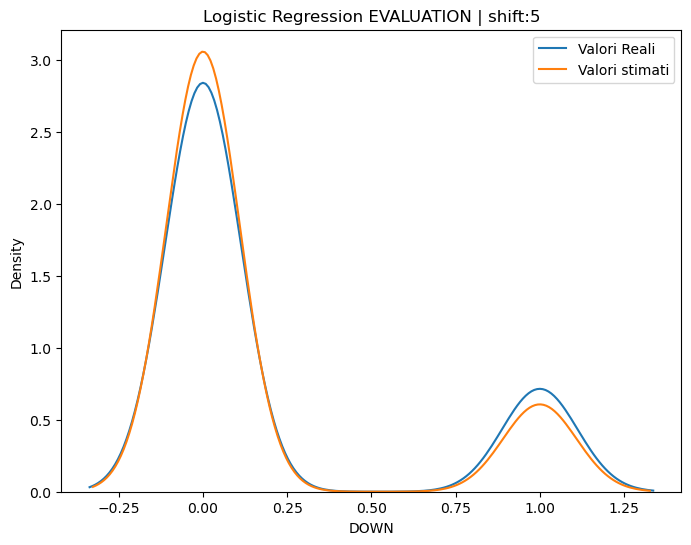

In [68]:
plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()

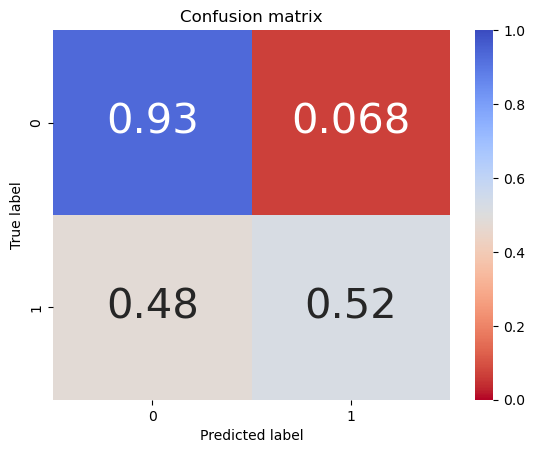

In [69]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [70]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.93150685 0.52      ]
The Precision is: [0.87628866 0.67532468]
The False positive rate is: [0.48       0.06849315]
The False Negative Rate is:  [0.06849315 0.48      ]


## Regressione Lineare Multivariata

           RLM
Reg           
prob  0.687219
BAR   -0.08369
Ay   -0.077128
Ax    0.009407
Gx    0.002585
Gz   -0.001992
Az    0.001366
Gy   -0.000464
P          0.0
R          0.0
Termine noto: 83.34438334667706
 
Precisione:  0.3335691938903316


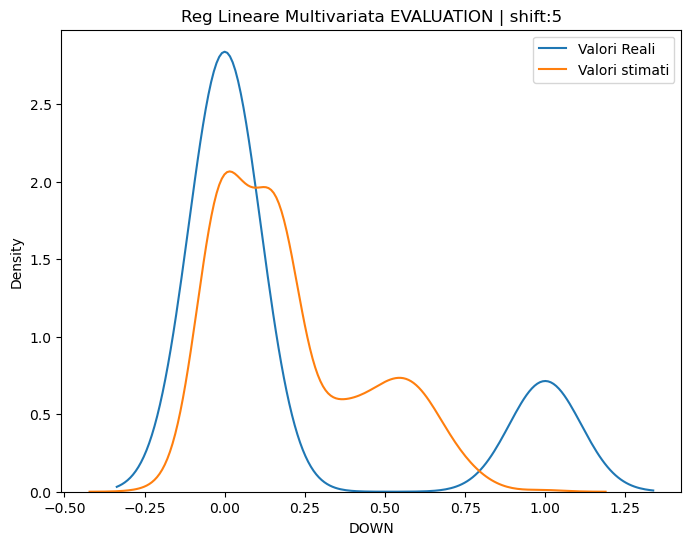

In [71]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'RLM'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='RLM', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('Precisione: ', mlr.score(X, y))

plt.figure(figsize=(8, 6))
plt.title('Reg Lineare Multivariata EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
